<a class="anchor" id="anch_top"> </a>
# Heart Disease Classifier using [Naïve-Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)

The aim of this project is to answer the following question:
* Given a set of attributes from a patient dataset, does this patient have heart disease?

We will employ the classical statistical classifier, called the Naïve-Bayes classifier on our dataset. To get a good handle on the key tasks required for this project, I will follow the "Data Science Process" (see figure below). This approach is inspired by Chanin Nantasenamat's (a.k.a. the Data Professor's) [post](https://towardsdatascience.com/the-data-science-process-a19eb7ebc41b). 

![img](https://miro.medium.com/max/552/1*PzzcJA-cwXQ8hwlpM4DwbA@2x.jpeg)


There are five Data Science steps:
1. [Collection](#Collection)
2. [Cleaning](#Cleaning)
3. [Exploratory Data Analysis (EDA)](#EDA)
4. [Model Building](#ModelBuilding)
   * [Computing probabilities from the dataset](#ComputingProbabilities)
   * [Evaluating model performance](#EvaluatingPerf)
   * [Tuning Models](#TuningModels)
5. Model Deployment

Here, I will work through the first 4 steps. The final step of Model Deployment is quite fun and extensive, so let's do that in a separate project. :)

Let's get started!

<a id='Collection'></a>
## A) Collection

Here, we will ingest the data and check some relevant quantities.

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling as pp
from pandas_profiling import ProfileReport
pp.__version__

'2.10.0'

In [2]:
data_path = 'data/heart.csv'
df = pd.read_csv(data_path, sep=',')

In [3]:
df.head(3)    # Have a look at the first 3 lines to see what data we are dealing with

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1


<a id='Cleaning'></a>
## B) Cleaning

In [4]:
# Compute the descriptive statistics using the defined percentiles. Then, round the output to 2 decimal places for readability
df.describe(percentiles=[.05,.95]) \
  .round(2)                             

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00
mean,54.37,0.68,0.97,131.62,246.26,0.15,0.53,149.65,0.33,1.04,1.40,0.73,2.31,0.54
std,9.08,0.47,1.03,17.54,51.83,0.36,0.53,22.91,0.47,1.16,0.62,1.02,0.61,0.50
min,29.00,0.00,0.00,94.00,126.00,0.00,0.00,71.00,0.00,0.00,0.00,0.00,0.00,0.00
5%,39.10,0.00,0.00,108.00,175.00,0.00,0.00,108.10,0.00,0.00,0.00,0.00,1.00,0.00
50%,55.00,1.00,1.00,130.00,240.00,0.00,1.00,153.00,0.00,0.80,1.00,0.00,2.00,1.00
95%,68.00,1.00,3.00,160.00,326.90,1.00,1.00,181.90,1.00,3.40,2.00,3.00,3.00,1.00
max,77.00,1.00,3.00,200.00,564.00,1.00,2.00,202.00,1.00,6.20,2.00,4.00,3.00,1.00


From the `df.describe` output, it looks like the dataset is quite clean! For example, all values are present (`count`=303) and there are no `NaN`-values. It turns out that our dataset, which was obtained [via Kaggle](https://www.kaggle.com/ronitf/heart-disease-uci), has been cleaned for us. Quite convenient!

In [5]:
# Now, make the keys more human-readable
data = df.rename(columns={
    "age": "Age", 
    "sex": "Sex",                  # 0=female, 1=male
    "cp": "ChestPainType",         # 0=No pain, >0=Pain
    "trestbps": "RestBloodPress", 
    "fbs": "FastingBloodSugar",
    "chol": "SeremCholestorol",
    "restecg": "RestingECG",
    "ca": "NumMajorVessels",
    "exang": "ExercisedInduced"
}).copy()

# Drop some columns that we think we do not need
data = data.drop(['RestBloodPress','SeremCholestorol','slope','thal','target'],axis=1)

<a style="color:blue" href="#anch_top">Back to top</a>

<a id='EDA'></a>
## C) Exploratory Data Analysis 

First, let's have a look at some general statistics from the `df.describe` output:
* Mean age is ~54 years old
* Dataset appears slightly biased towards male patients

A more efficient way of examining the statistical profile of the data is by using the `pandas-profiling` package (installed using `pip install pandas-profiling`). With the cleaned dataframe, we can simply obtain the profile report calling `ProfileReport(df, **kwargs)`. The report will be generated in a tidy embedded html output, as follows:

In [6]:
ProfileReport(data, title='Pandas Profiling Report for Full Dataset', html={'style':{'full_width':True}})

Summarize dataset:   0%|          | 0/22 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

From the report, we can more clearly see the distinction between continuous values (e.g. `Age`, `thalach`, `oldpeak`) and discrete categorical datas, such as `Sex`, `ChestPainType`, `FastingBloodSugar` and others. For the purposes of learning, let's keep things simple by using the *frequency* of the categorical data. A few more clean up steps:

* Classify the `ChestPainType` into yes or no. 
* Use the four categorical features:
  * `Sex`
  * `FastingBloodSugar`
  * `RestingECG`
  * `ExercisedInduced` 
* Split into training/testing set.

In [7]:
def clean_dataframe(dataf):
    return (dataf
             .assign(ChestPain=lambda d: (d['ChestPainType'] >= 1).astype(np.int)))


In [8]:
clean_df = data.pipe(clean_dataframe)
clean_df.loc[(clean_df['RestingECG'] == 2), 'RestingECG'] = 1

In [9]:
# Now construct the dataset for training and testing
X = clean_df[['Sex','FastingBloodSugar','RestingECG','ExercisedInduced',]].to_numpy()
Y = clean_df[['ChestPain']].to_numpy().squeeze()

<a style="color:blue" href="#anch_top">Back to top</a>

<a id='ModelBuilding'></a>
## D) Model Building
<a id='ComputingProbabilities'></a>
### i) Computing probabilities using training data
Let's start by using a subset of the categories. This means we do not do feature engineering, but rely on on intuition for the first steps of the data. Let's see how well the prediction goes.

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# First split the data to the training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [12]:
from sklearn.naive_bayes import BernoulliNB

In [13]:
alpha = 1
fit_prior = True
clf = BernoulliNB(alpha=alpha, fit_prior=fit_prior)
clf.fit(X_train, Y_train)

prediction_prob = clf.predict_proba(X_test)
prediction = clf.predict(X_test)
accuracy = clf.score(X_test, Y_test)

print('Accuracy is {:.1f}%'.format(accuracy*100))

Accuracy is 77.0%


An accuracy of 77% is pretty good! Let us strengthen our measure of the model performance with balanced metrics. For that, we utilise the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) a.k.a. the error matrix (an indispensible method for statistical machine learning) and the $F_1$-score, which is a [balanced measure of the accuracy of the test](https://en.wikipedia.org/wiki/F-score), and the subscript 1 applies a weight of 1 on the recall value versus precision value.

<a id='EvaluatingPerf'></a>
### ii) Evaluating performance of the probabilistic classifier

In [14]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

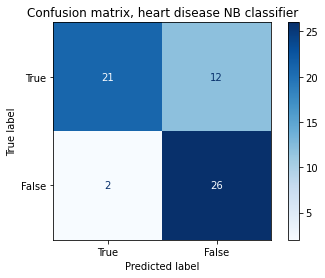

[[26  2]
 [12 21]]


In [15]:
disp = plot_confusion_matrix(clf, X_test, Y_test,                        # Pretty way of showing the confusion matrix, nice!
                                 display_labels=[True, False],
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix, heart disease NB classifier")
plt.show()

print(confusion_matrix(Y_test, prediction, labels=[True, False]))        # This is a less pretty way of showing the confusion matrix

**Precision** is the measure of your accurate your predictions are, that is, the ratio of true positives / (all positive measures). In this case, it is 26/(26+12) = 0.684. **Recall** is the measure of your true positive predictions / (all known actual positives). In this case, it is 26/(26+2) = 0.929. A better metric is the $F_1$ score, which balances both precision and recall by their harmonic mean, that is $F_1 = 2*precision*recall/(precision + recall)$.

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [17]:
print('Precision score = {:.3f}'.format(precision_score(Y_test, prediction, pos_label=True)))
print('Recall score = {:.3f}'.format(recall_score(Y_test, prediction, pos_label=True)))
print('f1 score = {:.3f}'.format(f1_score(Y_test, prediction, pos_label=True)))

Precision score = 0.684
Recall score = 0.929
f1 score = 0.788


Thanks to the `scikit-learn` authors, the reporting has been made much easier by simply calling `classification_report`, and passing as arguments the test-set and predictions:

In [18]:
target_names = ['False','True']
report = classification_report(Y_test, prediction, target_names=target_names)
print(report)

              precision    recall  f1-score   support

       False       0.91      0.64      0.75        33
        True       0.68      0.93      0.79        28

    accuracy                           0.77        61
   macro avg       0.80      0.78      0.77        61
weighted avg       0.81      0.77      0.77        61



There are other ways to optimise the prediction. For example, we can assess the relative importance of features using feature engineering. (Since feature engineering is a rich topic, this will be covered separately.) On the other hand, based on our simple binary probabilistic classifier, we can still tune several hyperparameters, such as
* The Laplace smoothing parameter, which we set as 1 now. 
* Probability thresholds for determining the `True` or `False` presence of heart disease.

To help with the tuning, we can use the values from **R**eceiver **O**perating **C**haracteristic (ROC). The values will produce a curve of true positive rates versus false positive rates for the combination of the two above hyperparameters. An _ideal_ ROC curve exhibits large values of true positive rates across all false positive rates. In other words, the **A**rea **U**nder the **C**urve of the ROC is larger and $\rightarrow 1$ for well tuned hyperparameters.

In [19]:
from sklearn.metrics import roc_auc_score

In [20]:
auc_value = roc_auc_score(Y_test, prediction_prob[:,1])
print('AUC is {:.5f} for alpha = {:.1f} and fit_prior = {}'.format(auc_value,alpha,fit_prior))

AUC is 0.81006 for alpha = 1.0 and fit_prior = True


As a rule-of-thumb, values of AUC > 0.7-0.8 are considered acceptable. Of course, AUC > 0.8 is much better, so our prediction model is pretty remarkable! This exercise indicates the potency of the Naïve Bayes approach for simple classification problems. 

<a id='TuningModels'></a>
### iii) Tuning models with cross-validation

Now, let's tune our model by iteratively training and testing a set of models across subsets of the data. The typical method to apply here is the k-fold cross-validation technique. At the end, we will average the performance across all $k$ trials. This averaging process produces a better representative view of the robustness of the model, as opposed to a single training-testing report/AUC scoring.

In [21]:
from sklearn.model_selection import StratifiedKFold
k = 5
k_fold = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)

In [22]:
laplace_smoothing_factor_option = np.arange(1,7)  # Set a range of smoothing factors
fit_prior_option = [True,False]                   # Set both fit_prior options
auc_record = {}

In [23]:
for train_indices, test_indices in k_fold.split(X, Y):
    X_train, X_test = X[train_indices], X[test_indices]
    Y_train, Y_test = Y[train_indices], Y[test_indices]
    
    for alpha in laplace_smoothing_factor_option:
        if alpha not in auc_record:
            auc_record[alpha] = {}
            
        for fit_prior in fit_prior_option:
            clf = BernoulliNB(alpha=alpha, fit_prior=fit_prior)
            clf.fit(X_train, Y_train)
            prediction_prob = clf.predict_proba(X_test)
            pos_prob = prediction_prob[:, 1]
            auc = roc_auc_score(Y_test, pos_prob)
            auc_record[alpha][fit_prior] = auc + auc_record[alpha].get(fit_prior, 0.0)

In [24]:
print('Smoothing  Fit_Prior  AUC')
for smoothing, smoothing_record in auc_record.items():
    for fit_prior, auc in smoothing_record.items():
        print(f'{smoothing}          {fit_prior}    {auc/k:.8f}')

Smoothing  Fit_Prior  AUC
1          True    0.74566656
1          False    0.74566656
2          True    0.74178725
2          False    0.74178725
3          True    0.74178725
3          False    0.74178725
4          True    0.74178725
4          False    0.74178725
5          True    0.74178725
5          False    0.74178725
6          True    0.74178725
6          False    0.74178725


For the highest AUC, it looks like our original smoothing value of 1 and `fit_prior` setting of `True` has given the best score. That's very convenient! We can repeat the calculation one more time as a sanity check (remember to reinitialise the `train_test_split`, otherwise the fit will be based on the `X_train` and `Y_train` from the k_fold tests.

In [25]:
clf = BernoulliNB(alpha=1.0, fit_prior=True)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
clf.fit(X_train, Y_train)
pos_prob = clf.predict_proba(X_test)[:, 1]
print('AUC with the best model:', roc_auc_score(Y_test, pos_prob))

AUC with the best model: 0.810064935064935


And that's it for this exercise! Here, we've shown how potent the simple probabilistic machine learning method using Naïve Bayes is in classifying heart disease based on a small dataset.

## Saving model for creating web app
Here, we will save the model `clf` to be used in a simple web-app. To do so, we will `pickle` the model.

In [26]:
import pickle

In [27]:
filename = "./models/heartdisease_NB_model.p"
pickle.dump(clf, open(filename, 'wb'))

We will use this `pickle`'d model file as input for our webapp on `streamlit`!

<a style="color:blue" href="#anch_top">Back to top</a>